# Diabetes Disease Prediction

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve)
from xgboost import XGBClassifier, plot_importance
import shap
from imblearn.over_sampling import SMOTE
from collections import Counter

pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
np.random.seed(42)

#Dataset Loading
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

## Exploratory Data Analysis

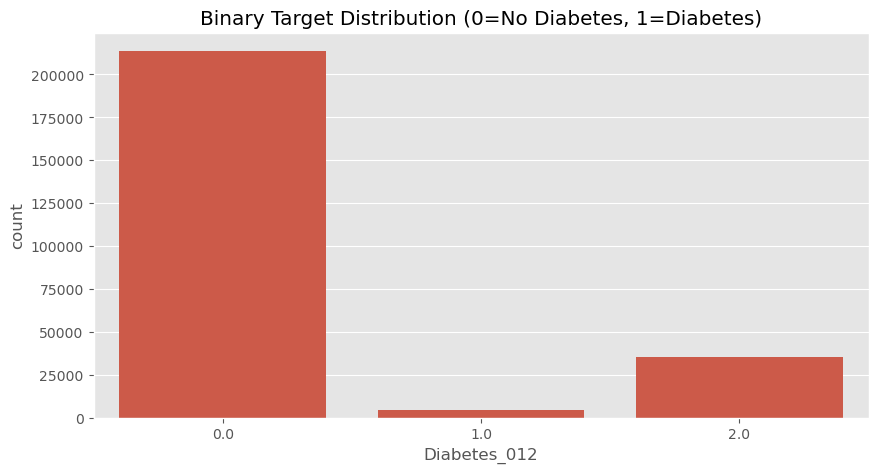

In [3]:
#Target Distribution (Binary)
plt.figure(figsize=(10,5))
sns.countplot(x='Diabetes_012', data=df)
plt.title("Binary Target Distribution (0=No Diabetes, 1=Diabetes)")
plt.show()

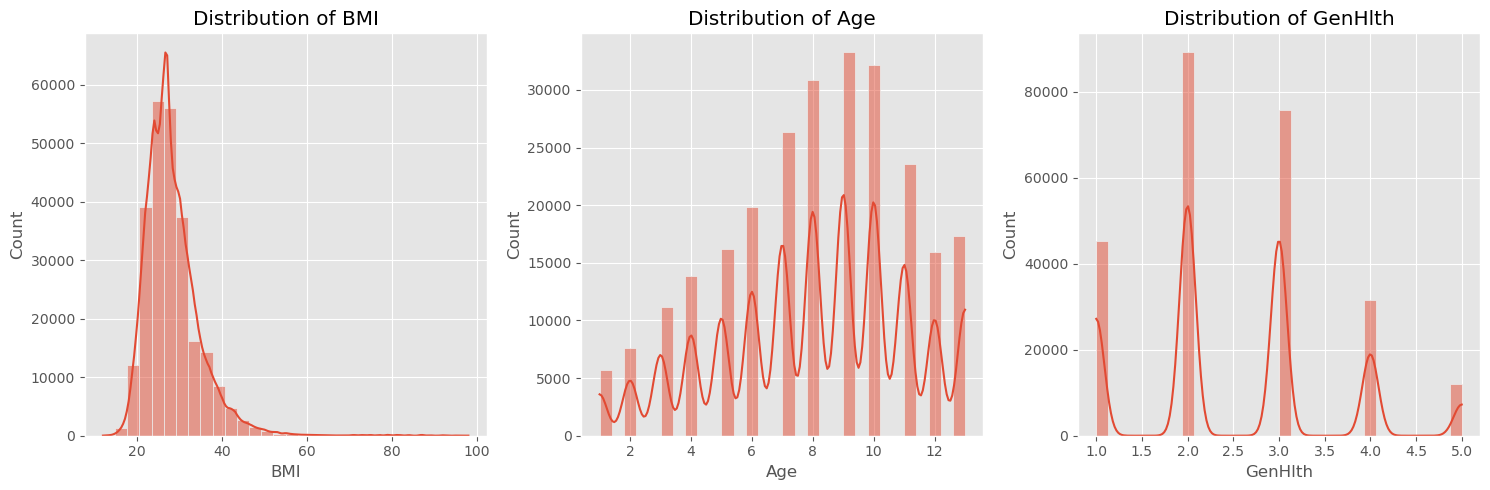

In [4]:
#Numeric Feature Distributions
numeric_features = ['BMI', 'Age', 'GenHlth']
plt.figure(figsize=(15,5))
for i, feat in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[feat], kde=True, bins=30)
    plt.title(f'Distribution of {feat}')
plt.tight_layout()
plt.show()

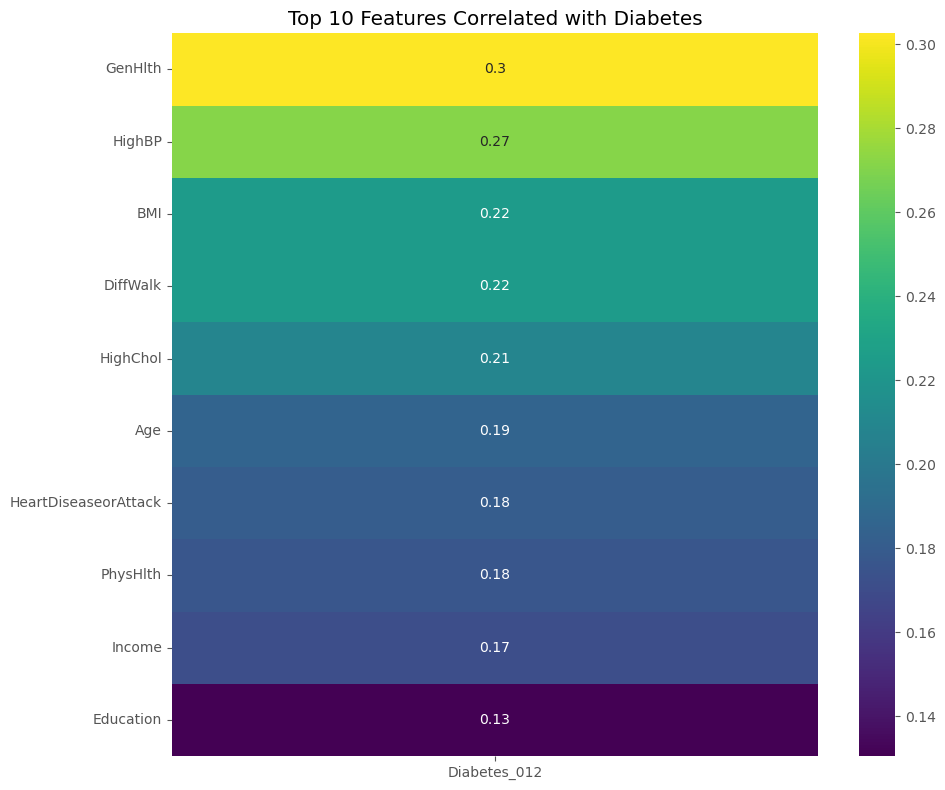

In [5]:
#Feature Correlation 
plt.figure(figsize=(10,8))
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix['Diabetes_012'].sort_values(ascending=False)[1:11].to_frame(), 
            annot=True, cmap='viridis')
plt.title("Top 10 Features Correlated with Diabetes")
plt.tight_layout()
plt.show()

## Feature Selection

In [6]:
#Converting target to binary
df['Diabetes'] = df['Diabetes_012'].replace({0:0, 1:1, 2:1})

features = [
    'HighBP', 'HighChol', 'BMI', 
    'HeartDiseaseorAttack', 'GenHlth',
    'PhysActivity', 'Age', 'Income'
]
X = df[features]
y = df['Diabetes']

## Data Preparation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)
y_train_orig = y_train.copy()  #To maintain a copy for visualization


#Applying SMOTE 
print("\nClass Distribution Before SMOTE:", dict(Counter(y_train)))
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Class Distribution After SMOTE:", dict(Counter(y_train)))


Class Distribution Before SMOTE: {1.0: 31982, 0.0: 170962}
Class Distribution After SMOTE: {1.0: 170962, 0.0: 170962}


<Figure size 1000x500 with 0 Axes>

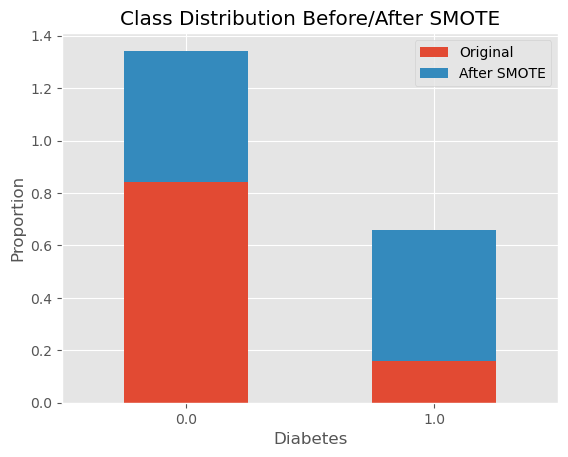

In [8]:
#Class Balance Comparison
plt.figure(figsize=(10,5))
pd.DataFrame({
    'Original': y_train_orig.value_counts(normalize=True),
    'After SMOTE': pd.Series(y_train).value_counts(normalize=True)
}).plot(kind='bar', stacked=True)
plt.title("Class Distribution Before/After SMOTE")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

## Model Training (Random Forest Classifier)

In [9]:
rf_model = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Max depth of each tree
    min_samples_split=5,    # Minimum samples required to split an internal node
    min_samples_leaf=2,     # Minimum samples required at a leaf node
    random_state=42,        # Ensures reproducibility
    n_jobs=-1               # Use all CPU cores
)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

# Evaluating the model
print("Random Forest Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred)*100:.2f}")
print("Classification Report:\n", classification_report(y_test, rf_y_pred))

Random Forest Classifier Performance:
Accuracy: 76.33
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.78      0.85     42741
         1.0       0.36      0.68      0.47      7995

    accuracy                           0.76     50736
   macro avg       0.65      0.73      0.66     50736
weighted avg       0.84      0.76      0.79     50736



### Hyparameter Tuning for Random Forest Model

In [10]:
# Defining parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'class_weight': ['balanced']
}

# Setting random search
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Best model
best_rf = rf_random.best_estimator_

# Predict
rf_y_pred = best_rf.predict(X_test)

# Evaluate
print("Tuned Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred):.4f}")
print(classification_report(y_test, rf_y_pred))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Tuned Random Forest Performance:
Accuracy: 0.7824
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86     42741
         1.0       0.38      0.61      0.47      7995

    accuracy                           0.78     50736
   macro avg       0.65      0.71      0.67     50736
weighted avg       0.83      0.78      0.80     50736



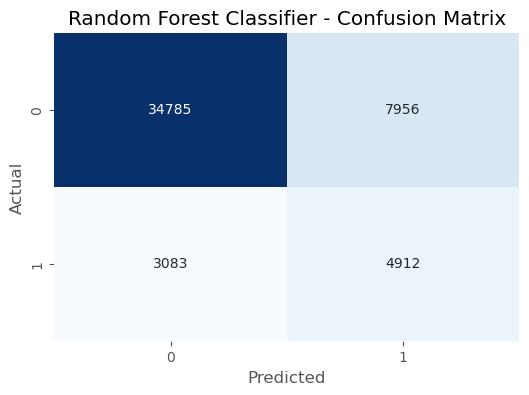

In [11]:
# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Classifier - Confusion Matrix')
plt.show()

## Model Training(XGBoost Classifier)

In [12]:
model = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### HyperParameter Tuning for XGBoost Model

In [13]:
y_proba = model.predict_proba(X_test)[:,1]  #Getting diabetes probabilities

#Testing different thresholds
thresholds = [0.3, 0.35, 0.45]
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int) 
    print(f"\n Threshold {thresh}:")
    print(classification_report(y_test, y_pred))
    


 Threshold 0.3:
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     42741
         1.0       0.29      0.86      0.43      7995

    accuracy                           0.64     50736
   macro avg       0.62      0.73      0.59     50736
weighted avg       0.85      0.64      0.69     50736


 Threshold 0.35:
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     42741
         1.0       0.31      0.82      0.45      7995

    accuracy                           0.68     50736
   macro avg       0.63      0.74      0.61     50736
weighted avg       0.85      0.68      0.73     50736


 Threshold 0.45:
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83     42741
         1.0       0.35      0.72      0.47      7995

    accuracy                           0.74     50736
   macro avg       0.64      0.73      0.65     50736
weighted avg       0.

### Applying Best Threshold

              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83     42741
         1.0       0.35      0.72      0.47      7995

    accuracy                           0.74     50736
   macro avg       0.64      0.73      0.65     50736
weighted avg       0.84      0.74      0.77     50736



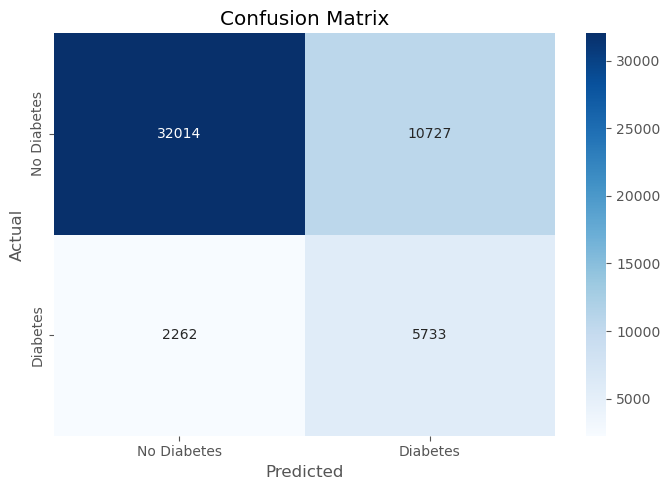

In [14]:
y_pred = (y_proba >= 0.45).astype(int)  
print(classification_report(y_test, y_pred))

#Confusion Matrix
plt.figure(figsize=(7,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

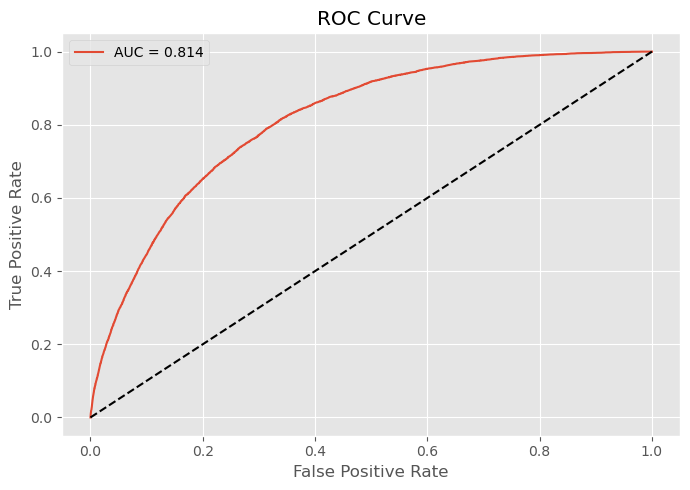

In [15]:
#ROC Curve
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\hkssf\AppData\Local\Temp\ipykernel_87512\3779540328.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


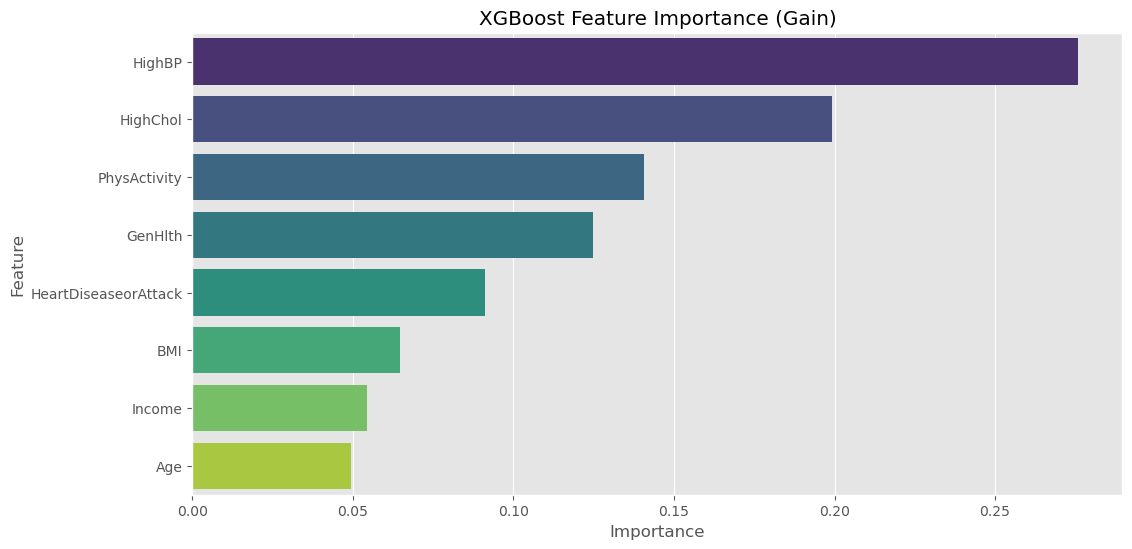

In [16]:
#Plotting Feature Importance
plt.figure(figsize=(12,6))
feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

## Model Comparison(Random Forest vs XGBoost)

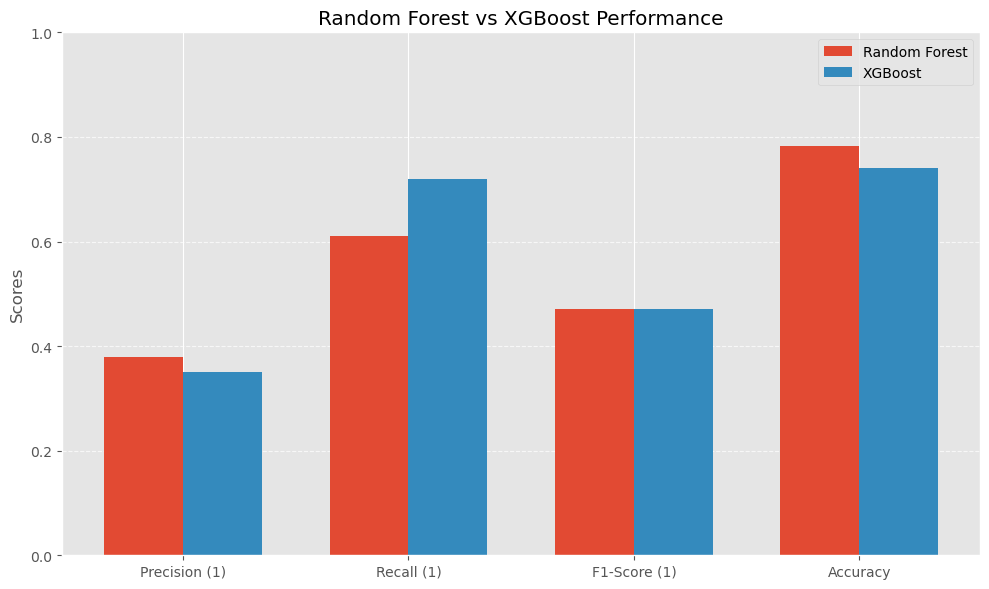

In [17]:
# Random Forest metrics
precision_rf = 0.38
recall_rf = 0.61
f1_rf = 0.47
accuracy_rf = 0.7824 

# XGBoost metrics
precision_xgb = 0.35
recall_xgb = 0.72
f1_xgb = 0.47
accuracy_xgb = 0.74

metrics_rf = [precision_rf, recall_rf, f1_rf, accuracy_rf]
metrics_xgb = [precision_xgb, recall_xgb, f1_xgb, accuracy_xgb]


# Setting up the plot
labels = ['Precision (1)', 'Recall (1)', 'F1-Score (1)', 'Accuracy']
x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, metrics_rf, width, label='Random Forest')
rects2 = ax.bar(x + width/2, metrics_xgb, width, label='XGBoost')

ax.set_ylabel('Scores')
ax.set_title('Random Forest vs XGBoost Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
